## Predictive Modeling (Clay Court Version)

### Summary of Previous Stage (see Notebook 4; Preprocessing_Training_Claycourt)

#### 5 Linear Regression "Benchmark" models were generated:
* 1) A "dummy" model, which simply uses the mean of the training data split to predict the target of % points won by a given player in a given match
    * Root Mean Squared Error (RMSE) Training Set: 6.46%;  Test Set: 6.54% 
* 2) A multivariate linear model that uses as predictive features only 1- difference in ranking between the two players, 2- difference in log of the rankings of the two players, and 3- difference in rankings points between the two players. Given that tournament entry and seeding are determined primarily by ranking data by the tour itself, this simple model can very prudently be seen as a fair benchmark for any system hoping to predict player performance on a move-forward basis.
    * Root Mean Squared Error (RMSE) Training Set: 5.93% (.15%);  Test Set: 6.01% 
* 3) A univariate linear model using implied win probabilities (IWPs) derived from aggregate closing wagering lines from a number of reputable sportsbooks (exact books aggregate vary by specific match) as predictive features.
    * Root Mean Squared Error (RMSE) Training Set: 5.61% (.13%);  Test Set: 5.66% 
* 4) A univariate linear model using IWPs derived only from Pinnacle Sports' closing wagering lines as predictive features. Pinnacle is considered to be one of the "sharpest" sportsbook, with closing lines typically being highly efficient.
    * Root Mean Squared Error (RMSE) Training Set: 5.62% (.12%);  Test Set: 5.66% 
* 5) A univariate linear model using only Opening Line data from Pinnacle Sports (via Oddsportal). Though not as efficent as the closing lines, which reflect the sum total of the "wisdom of the markets" (including insider info) right up to match time, these lines are still quite efficient. 
    * Root Mean Squared Error (RMSE) Training Set: 5.64%(.13%); Test Set: 5.66%
 
75%/25% Train/Test split was used for each of these Benchmark models


### High-Level Overview of Clay Court Modeling

Prediction is to be carried out at the player level for a given match (so each match in the sample has two records associated with it). Performance features used for prediction of a given player's % pts won in a given match are accrued based on  surface-specific (with a few exceptions) match data in matches PRIOR TO BUT NOT INCLDING the match being predicted nor any subsequent matches. 

The large majority of features included in the modeling stage are "differential", meaning that their values result from subtraction of previously calculated values for each of the two players in the match being predicted (Player X - Player Y or Player Y - Player X). As a simple example (actual features are typically adjusted in a number of ways before this stage) if Player X won 55% of his previous service points and his opponent (Player Y) won 47% of his own serve points the "differential" feature value "player_past_service_pts_diff" for Player X would be 55 - 47 = 8% and for Player Y would be 47 - 55 = -8%.  

Based on the results of prevous modeling iterations, data from the years 2015-2019 are currently included in the clay court-specific model, with an additional prior 3 years (2012-2014) used in statistical accrual for feature generation. Also, a threshold of minimum of 20 prior matches for BOTH players in a given match to be predicted is employed. Not surprisingly, prediction accuracy is sensitive to the amount of data available to generate predictive features, as well as to the amount of data available to train and test the model. Critically, matches filtered out at the current point and beyond (ie, during modeling) WERE used during statistical accruals for feature generation. Also of note, matches which lasted fewer than 12 games were filtered out BEFORE statistical accruals for feature generation.

Four regression models are evaluated presently. First is simply a Linear Regression Model. The subsequent three models are decision tree models: Random Forest, Gradient Boosting Regressor and HistGradient Boosting Regressor. The latter is an ensemble machine learning algorithm that is very fast (relative to standard gradient boosting models), and performs well on heterogenous data sets. Boosting, generally, refers to a class of ensemble learning algorithms that add tree models to an ensemble sequentially. 


### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
#from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load and Filter Data

Filtering parameters identical to in dummy/simple modeling stage. 

In [2]:
# Ths is the file and analysis data range used for the main clay court analysis
df = pd.read_csv('../data/processed_data/df_for_modeling.csv')
df.head()

,p_tot_pts_won%,t_ident,t_surf,t_ind,t_alt,t_draw_sz,t_lvl,m_bestof,m_num,m_date,...,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff,p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff
0,54.19,91,2,1,0,8,3,3,28534,2019-11-17,...,-0.02,-0.01,-0.01,-0.01,-0.02,-0.01,-0.02,0.00,-0.02,0.00
1,45.81,91,2,1,0,8,3,3,28534,2019-11-17,...,0.02,0.01,0.01,0.01,0.02,0.01,0.02,0.00,0.02,0.00
2,53.15,91,2,1,0,8,3,3,28533,2019-11-16,...,-0.01,0.01,0.00,0.01,-0.01,0.01,0.00,0.01,-0.01,0.00
3,46.85,91,2,1,0,8,3,3,28533,2019-11-16,...,0.01,-0.01,0.00,-0.01,0.01,-0.01,0.00,-0.01,0.01,0.00
4,54.74,91,2,1,0,8,3,3,28532,2019-11-16,...,-0.03,-0.02,-0.05,-0.03,-0.03,-0.02,-0.05,-0.03,-0.04,-0.03


In [3]:
# Select Clay Court Surface matches only 
df_filter = df.loc[(df["t_surf"] == 1)]

In [4]:
# Select match year inclusion for modeling. 
# As noted in Intro, an additonal three years (2012-2014) were used in feature development to accrue stats-based features for matches within the modeling time range
df_filter = df_filter.loc[(df_filter["m_yr"] == 2019) | (df_filter["m_yr"] == 2018) | (df_filter["m_yr"] == 2017) | (df_filter["m_yr"] == 2016) | (df_filter["m_yr"] == 2015)]

In [5]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted. 
df_low_pass = df_filter.loc[df_filter['p_matches_ss'] <= 20, 'm_num']
df_filter = df_filter[~df_filter['m_num'].isin(df_low_pass)]

In [ ]:
df_filter.info()

In [6]:
#Pared down to just the predictive features and the target feature itself 
# All features are derived from data available prior to any given match being predicted on. No data leakage!

df_model1 = df_filter[['p_tot_pts_won%', 't_ind', 't_alt', 't_draw_sz', 't_lvl', 'm_bestof', 'm_rd_num', 'p_ent', 'p_age', 't_1st_sv_in%_ratio', 't_1st_sv_in%_yielded_ratio', 't_sv_pts_won%_ratio', 't_ret_pts_won%_ratio', 't_1st_sv_pts_won%_ratio', 't_1st_ret_pts_won%_ratio', 't_2nd_sv_pts_won%_ratio', 't_2nd_ret_pts_won%_ratio', 't_ace%_ratio', 't_aced%_ratio', 't_df%_ratio', 't_df_induce%_ratio', 't_bp_save%_ratio', 't_bp_conv%_ratio', 'p_rk_diff', 'p_log_rk_diff', 'p_rk_pts_diff', 'p_ent_diff', 'p_hd_diff', 'p_ht_diff', 'p_age_diff', 'p_HCA', 'p_HCA_diff', 'p_tot_time_l7d_tw_diff', 'p_tot_pts_l7d_tw_diff', 'p_body_battery_t_tw_diff', 'p_body_battery_pts_tw_diff', 'p_matches_ss_diff', 'p_matches_nss_diff', 'p_surf_chg_diff', 'p_tz_chg_diff', 'p_H2H_w_ss_diff', 'p_H2H_w_nss_diff', 'p_H2H_tot_pts_won%_ss_diff', 'p_H2H_tot_pts_won%_nss_diff', 'p_tot_pts_won%_l60_tw_ss_diff', 'p_tot_pts_won%_l10_tw_ss_diff', 'p_tot_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_tot_pts_won%_l60_tw_ss_IO_diff', 'p_tot_pts_won%_l10_tw_ss_IO_diff', 'p_tot_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_tot_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_diff', 'p_sv_pts_won%_l10_tw_ss_diff', 'p_sv_pts_won%_l60_tw_ss_IO_diff', 'p_sv_pts_won%_l10_tw_ss_IO_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_diff', 'p_1st_sv_pts_won%_l10_tw_ss_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_diff', 'p_1st_sv%_l10_tw_ss_diff', 'p_1st_sv%_l60_tw_ss_IO_diff', 'p_1st_sv%_l10_tw_ss_IO_diff', 'p_1st_sv%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_diff', 'p_1st_sv%_yielded_l10_tw_ss_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv%_yielded_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_diff', 'p_ret_pts_won%_l10_tw_ss_diff', 'p_ret_pts_won%_l60_tw_ss_IO_diff', 'p_ret_pts_won%_l10_tw_ss_IO_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_diff', 'p_1st_ret_pts_won%_l10_tw_ss_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_diff', 'p_ace%_l10_tw_ss_diff', 'p_ace%_l60_tw_ss_IO_diff', 'p_ace%_l10_tw_ss_IO_diff', 'p_ace%_l60_tw_ss_SOS_adj_diff', 'p_ace%_l10_tw_ss_SOS_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_diff', 'p_aced%_l10_tw_ss_diff', 'p_aced%_l60_tw_ss_IO_diff', 'p_aced%_l10_tw_ss_IO_diff', 'p_aced%_l60_tw_ss_SOS_adj_diff', 'p_aced%_l10_tw_ss_SOS_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_diff', 'p_df%_l10_tw_ss_diff', 'p_df%_l60_tw_ss_IO_diff', 'p_df%_l10_tw_ss_IO_diff', 'p_df%_l60_tw_ss_SOS_adj_diff', 'p_df%_l10_tw_ss_SOS_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_diff', 'p_df_induce%_l10_tw_ss_diff', 'p_df_induce%_l60_tw_ss_IO_diff', 'p_df_induce%_l10_tw_ss_IO_diff', 'p_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_diff', 'p_bp_save%_l10_tw_ss_diff', 'p_bp_save%_l60_tw_ss_IO_diff', 'p_bp_save%_l10_tw_ss_IO_diff', 'p_bp_save%_l60_tw_ss_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_save%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_save%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_save%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_diff', 'p_bp_conv%_l10_tw_ss_diff', 'p_bp_conv%_l60_tw_ss_IO_diff', 'p_bp_conv%_l10_tw_ss_IO_diff', 'p_bp_conv%_l60_tw_ss_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bp_conv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bp_conv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bp_conv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_sv_opp_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_sv_opp_1st_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_sv_opp_2nd_ret_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ret_opp_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_1st_ret_opp_1st_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff',
                              'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_2nd_ret_opp_2nd_sv_pts_won%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_opp_aced%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_opp_aced%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_SOS_csp_adj_diff', 'p_aced_opp_ace%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_aced_opp_ace%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_df_opp_df_induce%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_dfinduce_opp_df%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpsave_opp_bpconv%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_bpconv_opp_bpsave%_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_AVG_C_IP_l60_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_ss_IO_SOS_adj_diff', 'p_AVG_C_IP_l60_tw_nss_SOS_adj_diff', 'p_AVG_C_IP_l10_tw_nss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_diff', 'p_ace_df%_ratio_l10_tw_ss_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_df%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_ace_df%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_df%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_1stSvWon_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l60_tw_ss_IO_SOS_csp_adj_diff', 'p_ace_1stSv%_ratio_l10_tw_ss_IO_SOS_csp_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l60_tw_ss_IO_SOS_adj_csp_diff', 'p_df_SvPtsWon%_ratio_l10_tw_ss_IO_SOS_adj_csp_diff']]

In [ ]:
df_model1.info()

In [ ]:
df_model1.to_csv('../data/df_model1.csv', index=False)

### Data Split for Modeling

Identical split as for dummy/simple modeling

In [7]:
len(df_model1) * .75, len(df_model1) * .25

(3397.5, 1132.5)

In [8]:
#Replicates EXACT train-test split from dummy and simpler modeling
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_tot_pts_won%'), 
                                                    df_model1["p_tot_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [9]:
y_train.shape, y_test.shape

((3397,), (1133,))

In [10]:
y_train

8057     46.10
2800     51.58
8247     41.74
18409    55.56
12026    54.31
         ...  
18543    38.89
18278    49.15
3429     47.34
18928    57.66
13040    55.85
Name: p_tot_pts_won%, Length: 3397, dtype: float64

In [11]:
X_train.shape, X_test.shape

((3397, 367), (1133, 367))

## Linear Model

In [14]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [15]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [16]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean','median'],
    'selectkbest__k': k
}


In [17]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [18]:
#Conduct grid search. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002163A8CB940>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [19]:
#Best params from grid search
lr_grid_cv.best_params_

{'selectkbest__k': 15,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

### K Best Features Visualization

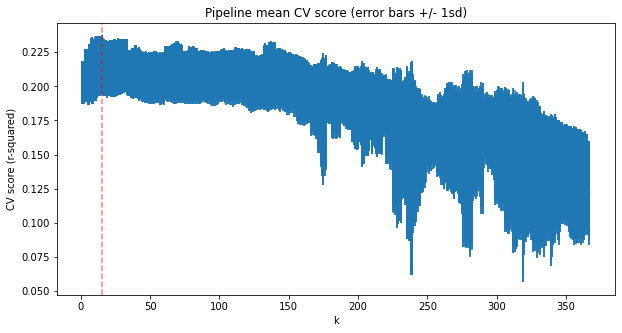

In [20]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Best Linear Model Performance Metrics

#### R-squared (COD)

In [21]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.21484238, 0.23948426, 0.18256134, 0.20102849, 0.23894651])

In [22]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.21537259357756086, 0.02199870390517733)

#### Mean Absolute Error (MAE)

In [23]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [24]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.501926254027614, 0.12546773829700858)

In [25]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.609964781909436

#### Mean Squared Error (MSE)

In [26]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [27]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(32.66246357980302, 1.5069561185341205)

In [28]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

33.10110841536499

#### Root Mean Square Error (RMSE)

In [29]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [30]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(5.713599018168386, 0.13133864392578334)

In [31]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

5.753356273981735

### Best Linear Model Feature Importance

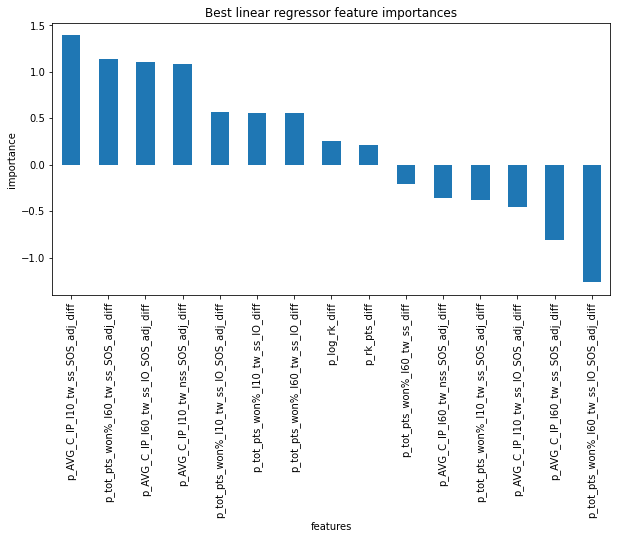

In [32]:
#Plot a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

## Random Forest Regression Model

### Random Forest Model: Hyperparameter Grid Search

In [33]:
#Define pipeline
RF_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [34]:
#Dict of available parameters for RF pipe
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'randomforestregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomf

In [35]:
#Define search grid parameters

#n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
n_est = [1000]

grid_params = {
        'randomforestregressor__n_estimators': n_est, 
        'randomforestregressor__max_features': [100],
        'randomforestregressor__max_depth': [75],
        'randomforestregressor__min_samples_split': [10],
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean']}
grid_params

# Final Hyperparameter Tuning Run
# {'randomforestregressor__n_estimators': [1000]
#  'randomforestregressor__max_features': [75, 100] 100
#  'randomforestregressor__max_depth': [75, 100] 75
#  'randomforestregressor__min_samples_split': [10] 
#  'standardscaler': [None],
#  'simpleimputer__strategy': ['mean']}

# The grid params currently in place performed the best of the combos explored for RF. See cell at bottom of this section for
# prediction quality per set of hyperparameters explored. 
#'randomforestregressor__min_samples_leaf': [50],

{'randomforestregressor__n_estimators': [1000],
 'randomforestregressor__max_features': [75, 100],
 'randomforestregressor__max_depth': [75, 100],
 'randomforestregressor__min_samples_split': [10],
 'standardscaler': [None],
 'simpleimputer__strategy': ['mean']}

In [36]:
#Call `GridSearchCV` with random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)

In [37]:
#Conduct grid search.  
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             param_grid={'randomforestregressor__max_depth': [75, 100],
                         'randomforestregressor__max_features': [75, 100],
                         'randomforestregressor__min_samples_split': [10],
                         'randomforestregressor__n_estimators': [1000],
                         'simpleimputer__strategy': ['mean'],
                         'standardscaler': [None]})

In [38]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__max_depth': 75,
 'randomforestregressor__max_features': 100,
 'randomforestregressor__min_samples_split': 10,
 'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Best Random Forest Model Performance Metrics

#### R-squared (COD)

In [39]:
#Cross-validation defaults to R^2 metric for scoring regression
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.21486692, 0.23808523, 0.17355883, 0.21644092, 0.23282276])

In [40]:
#Training set CV mean and std
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.21515493321503745, 0.02267122963008842)

#### Mean Absolute Error (MAE)

In [41]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5)

In [42]:
#Training set CV mean and std
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(4.487867751367219, 0.1263290675106757)

In [43]:
# Test set mean
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

4.582650590572313

#### Mean Squared Error (MSE)

In [44]:
rf_neg_mse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [45]:
#Training set CV mean and std
rf_mse_mean = np.mean(-1 * rf_neg_mse['test_score'])
rf_mse_std = np.std(-1 * rf_neg_mse['test_score'])
rf_mse_mean, rf_mse_std

(32.67307706470134, 1.5581418253482178)

In [46]:
# Test set mean
mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

33.138024574810416

#### Root Mean Square Error (RMSE)

In [47]:
rf_neg_rmse = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [48]:
#Training set CV mean and std
rf_rmse_mean = np.mean(-1 * rf_neg_rmse['test_score'])
rf_rmse_std = np.std(-1 * rf_neg_rmse['test_score'])
rf_rmse_mean, rf_rmse_std

(5.714430572797677, 0.13550016006099744)

In [49]:
# Test set mean
np.sqrt(mean_squared_error(y_test, rf_grid_cv.best_estimator_.predict(X_test)))

5.756563608161593

### Best Random Forest Model Feature Performance

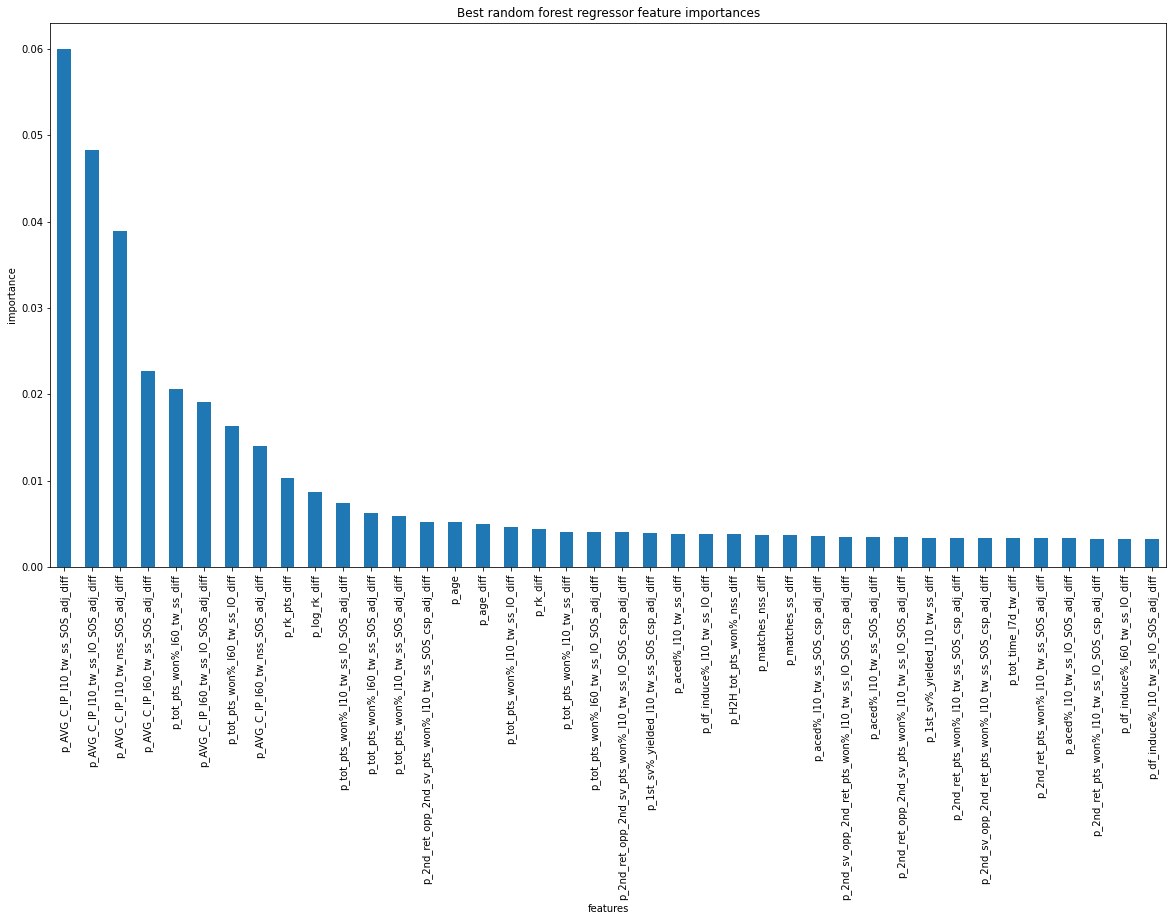

In [50]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.nlargest(40).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

#rf_gridsearch.best_estimator_.named_steps["step_name"].feature_importances_
#rf_gridsearch.best_estimator_.feature_importances_

#feat_importances = pd.Series(rf_grid_cv.feature_importances_, index=rf_grid_cv.columns)
#feat_importances.nlargest(50).plot(kind='barh')

Random Forest Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(5.714430572797677, 0.13550016006099744), 5.756563608161593

{'randomforestregressor__max_depth': 75,
 'randomforestregressor__max_features': 100,
 'randomforestregressor__min_samples_split': 10,
 'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}
 
 "it could take around 1000 seconds to fit an RF with around 4M samples with the dimensions 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': 20 but only 50s for 'n_estimators': 50, 'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_jobs': 20 for similar accuracy."

## Gradient Boosting Regression Model

### Gradient Boosting Model: Hyperparameter Grid Search

In [12]:
#Define pipeline 
GB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    GradientBoostingRegressor(random_state= 47)
)

In [13]:
GB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'gradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estim

In [14]:
#Define Grid Parameters

n_est = [130]
learning_rate = [.04]
max_depth = [3]
max_features = [11]


grid_params = {
        'gradientboostingregressor__n_estimators': n_est,
        'standardscaler': [None],
        'simpleimputer__strategy': ['median'],
        'gradientboostingregressor__learning_rate': learning_rate,
        'gradientboostingregressor__max_depth': max_depth,
        'gradientboostingregressor__max_features': max_features
}
grid_params

#First Pass
#n_est = [145, 150, 155] 145
#learning_rate = [.035, .04, .045] .04
#max_depth = [3, 4, 5] 3
#max_features = [10, 11, 12] 11
#'standardscaler': [None], None 
#'simpleimputer__strategy': ['median'], Median

#Second Pass
#n_est = [135, 140, 145] 135
#learning_rate = [.04] .04
#max_depth = [2, 3] 3
#max_features = [11] 11
#'standardscaler': [None], None 
#'simpleimputer__strategy': ['median'], Median

#Third (Final) Pass
#n_est = [125, 130, 135] 130
#learning_rate = [.04]
#max_depth = [3]
#max_features = [11]

#Current parameters reflect best hyperparameters from this set of exploratory passes

{'gradientboostingregressor__n_estimators': [130],
 'standardscaler': [None],
 'simpleimputer__strategy': ['median'],
 'gradientboostingregressor__learning_rate': [0.04],
 'gradientboostingregressor__max_depth': [3],
 'gradientboostingregressor__max_features': [11]}

In [15]:
#Call `GridSearchCV` with the gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
gb_grid_cv = GridSearchCV(GB_pipe, param_grid=grid_params, cv=5)

In [16]:
#conduct the grid search. 
gb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=47))]),
             param_grid={'gradientboostingregressor__learning_rate': [0.04],
                         'gradientboostingregressor__max_depth': [3],
                         'gradientboostingregressor__max_features': [11],
                         'gradientboostingregressor__n_estimators': [130],
                         'simpleimputer__strategy': ['median'],
                         'standardscaler': [None]})

In [17]:
#Best params (`best_params_` attribute) from the grid search
gb_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.04,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 11,
 'gradientboostingregressor__n_estimators': 130,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

### Best Gradient Boosting Model Performance Metrics

#### R-squared (COD)

In [18]:
#Cross-validation defaults to R^2 metric for scoring regression
gb_best_cv_results = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, cv=5)
gb_best_scores = gb_best_cv_results['test_score']
gb_best_scores

array([0.20177136, 0.23408227, 0.18183549, 0.21649095, 0.24321118])

In [19]:
#Training set CV mean and std
np.mean(gb_best_scores), np.std(gb_best_scores)

(0.21547825109121393, 0.022072447432598598)

#### Mean Absolute Error (MAE)

In [20]:
gb_neg_mae = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [21]:
#Training set CV mean and std
gb_mae_mean = np.mean(-1 * gb_neg_mae['test_score'])
gb_mae_std = np.std(-1 * gb_neg_mae['test_score'])
gb_mae_mean, gb_mae_std

(4.49859834918993, 0.1339651787835567)

In [22]:
# Test set mean
mean_absolute_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

4.613777801565661

#### Mean Squared Error (MSE)

In [23]:
gb_neg_mse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [24]:
#Training set CV mean and std
gb_mse_mean = np.mean(-1 * gb_neg_mse['test_score'])
gb_mse_std = np.std(-1 * gb_neg_mse['test_score'])
gb_mse_mean, gb_mse_std

(32.66441458610812, 1.6431701428946144)

In [25]:
# Test set mean
mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test))

33.271852473229906

#### Root Mean Square Error (RMSE)

In [26]:
gb_neg_rmse = cross_validate(gb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [27]:
#Training set CV mean and std
gb_rmse_mean = np.mean(-1 * gb_neg_rmse['test_score'])
gb_rmse_std = np.std(-1 * gb_neg_rmse['test_score'])
gb_rmse_mean, gb_rmse_std

(5.713487018914067, 0.14311069424948566)

In [28]:
# Test set mean
np.sqrt(mean_squared_error(y_test, gb_grid_cv.best_estimator_.predict(X_test)))

5.768175835845324

### Best Gradient Boosting Model Feature Performance

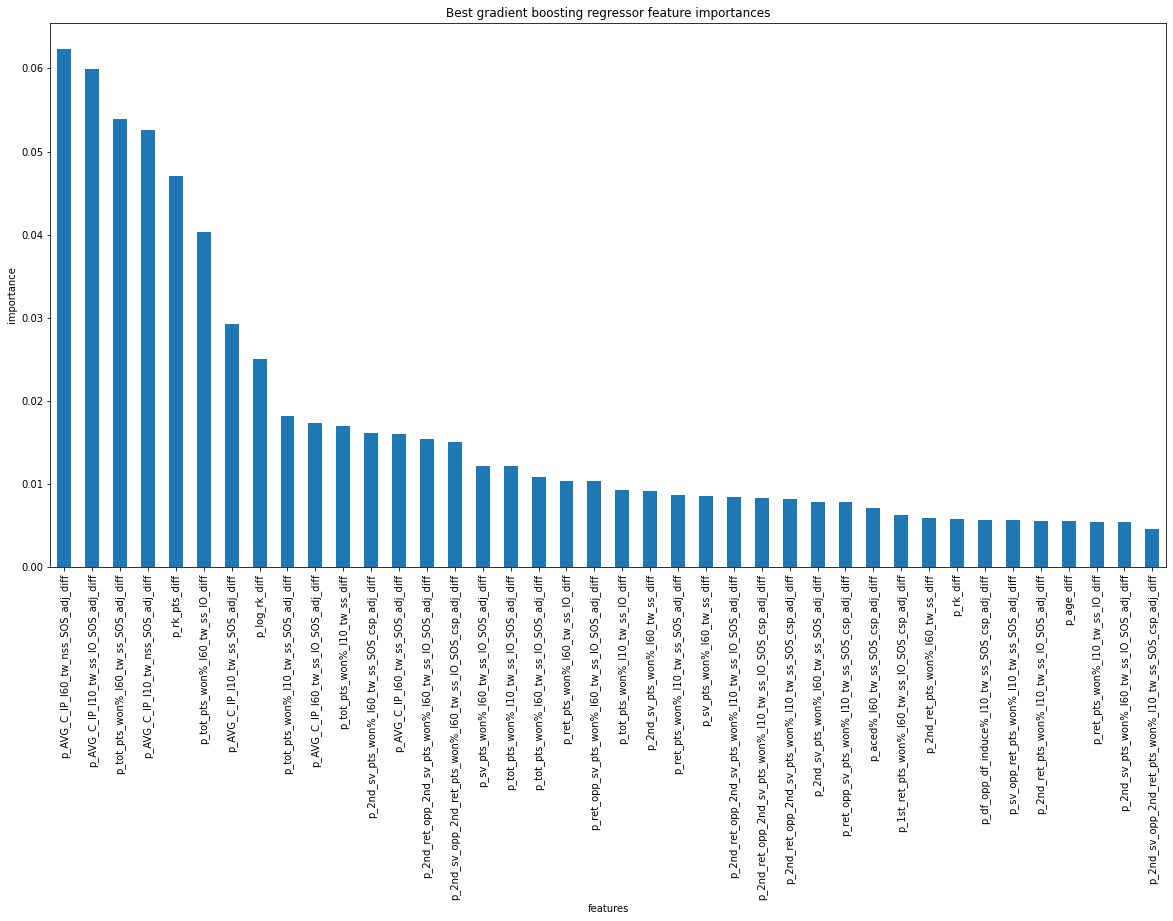

In [29]:
#Plot a barplot of the gradient boosting model's feature importances,
#assigning the `feature_importances_` attribute of 
#`gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(20, 10))
imps = gb_grid_cv.best_estimator_.named_steps.gradientboostingregressor.feature_importances_
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
gb_feat_imps.nlargest(40).plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best gradient boosting regressor feature importances');

#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(20).plot(kind='barh')

In [30]:
# Export out features and feature importances for full documentation csv
X_train.columns
gb_feat_imps.to_csv('../data/processed_data/gb_feat_imps_clay.csv', index=True)

### Data Quality Assessment

Because Gradient Boosting Regressor turned out to be the best of the four models tested (in terms of cross-validation RMSE) for hard courts, a Data Quality Assessment was run on this model to ensure that results are not hindered by sample size. Much more analysis of data size and year range of inclusion is conducted in the final reporting (see Reporting folder)

In [149]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, .9, 1.0]
train_size, train_scores, test_scores = learning_curve(GB_pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

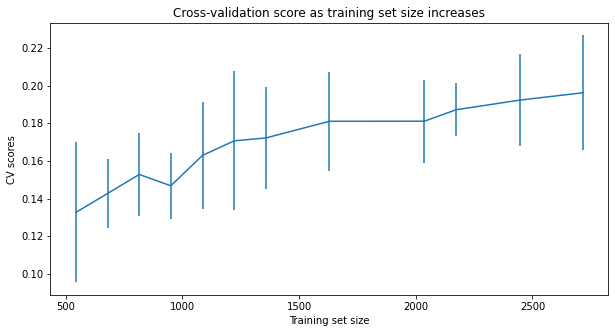

In [150]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(5.713487018914067, 0.14311069424948566), 5.768175835845324
{'gradientboostingregressor__learning_rate': 0.04,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 11,
 'gradientboostingregressor__n_estimators': 130,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

(5.714204470607363, 0.14265327315844295), 5.767567935606883
{'gradientboostingregressor__learning_rate': 0.04,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 11,
 'gradientboostingregressor__n_estimators': 135,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

## HistGradientBoosting Model

### Pipeline Creation

In [151]:
#Define pipeline
HGB_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    HistGradientBoostingRegressor(random_state= 47)
)

In [152]:
HGB_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'histgradientboostingregressor', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'histgradientboostingregressor__categorical_features', 'histgradientboostingregressor__early_stopping', 'histgradientboostingregressor__l2_regularization', 'histgradientboostingregressor__learning_rate', 'histgradientboostingregressor__loss', 'histgradientboostingregressor__max_bins', 'histgradientboostingregressor__max_depth', 'histgradientboostingregressor__max_iter', 'histgradientboostingregressor__max_leaf_nodes', 'histgradientboostingregressor__min_samples_leaf', 'histgradientboostingregressor__monotonic_cst', 'histgradientboostingregressor__n_iter_no_change', 'histgradientboostingregressor__random_state', 'histgradientboosting

### Hyperparameter  Grid Search and Model Fit Using Best Parameters from Grid Search

In [153]:
#Define grid search parameters

learning_rate = [.03]
max_iterations = [115]
max_depth = [2]

grid_params = {
        'standardscaler': [None],
        'simpleimputer__strategy': ['mean'],
        'histgradientboostingregressor__learning_rate': learning_rate,
        'histgradientboostingregressor__max_iter': max_iterations,
        'histgradientboostingregressor__max_depth': max_depth
}
grid_params

# First Pass
#{'standardscaler': [None],
#'simpleimputer__strategy': ['mean'],
# 'histgradientboostingregressor__learning_rate': [0.03, 0.035, 0.04],   .03
#'histgradientboostingregressor__max_iter': [110, 115, 120],  115
# 'histgradientboostingregressor__max_depth': [4, 5, 6]}  4

# Second Pass
#'standardscaler': [None],
#'simpleimputer__strategy': ['mean'],
#learning_rate = [.02, .025, .03] .03
#max_iterations = [115]
#max_depth = [2, 3, 4] 2

{'standardscaler': [None],
 'simpleimputer__strategy': ['mean'],
 'histgradientboostingregressor__learning_rate': [0.03],
 'histgradientboostingregressor__max_iter': [115],
 'histgradientboostingregressor__max_depth': [2]}

In [154]:
#Call `GridSearchCV` with the hist gradient boosting pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation.
hgb_grid_cv = GridSearchCV(HGB_pipe, param_grid=grid_params, cv=5)

In [155]:
#`GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
hgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(random_state=47))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.03],
                         'histgradientboostingregressor__max_depth': [2],
                         'histgradientboostingregressor__max_iter': [115],
                         'simpleimputer__strategy': ['mean'],
                         'standardscaler': [None]})

In [156]:
#Best params (`best_params_` attribute) from the grid search    
hgb_grid_cv.best_params_

{'histgradientboostingregressor__learning_rate': 0.03,
 'histgradientboostingregressor__max_depth': 2,
 'histgradientboostingregressor__max_iter': 115,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

### Model Cross-Validation and Fit Metrics

#### R-Squared (Training Cross Validation, then Testing)

In [157]:
#Cross-validation defaults to R^2 metric for scoring regression
hgb_best_cv_results = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, cv=5)
hgb_best_scores = hgb_best_cv_results['test_score']
hgb_best_scores

array([0.2038499 , 0.23189784, 0.17715867, 0.21235319, 0.24403872])

In [158]:
#Training set CV mean and std
np.mean(hgb_best_scores), np.std(hgb_best_scores)

(0.21385966197678868, 0.02317575999952487)

#### Mean Absolute Error (MAE)

In [159]:
hgb_neg_mae = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [160]:
#Training set CV mean and std
hgb_mae_mean = np.mean(-1 * hgb_neg_mae['test_score'])
hgb_mae_std = np.std(-1 * hgb_neg_mae['test_score'])
hgb_mae_mean, hgb_mae_std

(4.5149369820996395, 0.1411699333291203)

In [161]:
# Test set mean
mean_absolute_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

4.620697151820826

#### Mean Squared Error (MSE)

In [162]:
hgb_neg_mse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv= 5)

In [163]:
#Training set CV mean and std
hgb_mse_mean = np.mean(-1 * hgb_neg_mse['test_score'])
hgb_mse_std = np.std(-1 * hgb_neg_mse['test_score'])
hgb_mse_mean, hgb_mse_std

(32.732799704795134, 1.6899227604998124)

In [164]:
# Test set mean
mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test))

33.23989600187347

#### Root Mean Squred Error (RMSE)

In [165]:
hgb_neg_rmse = cross_validate(hgb_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [166]:
#Training set CV mean and std
hgb_rmse_mean = np.mean(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_std = np.std(-1 * hgb_neg_rmse['test_score'])
hgb_rmse_mean, hgb_rmse_std

(5.719366981832602, 0.147108911756477)

In [167]:
# Test set mean
np.sqrt(mean_squared_error(y_test, hgb_grid_cv.best_estimator_.predict(X_test)))

5.765405103015179

Hist Gradient Boosting Regressor RMSE Train(STD)/Test for different explored hyperparameter values (summarized below each)

(5.719366981832602, 0.147108911756477), 5.765405103015179
{'histgradientboostingregressor__learning_rate': 0.03,
 'histgradientboostingregressor__max_depth': 2,
 'histgradientboostingregressor__max_iter': 115,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

(5.738764216748416, 0.14259977063343918), 5.77202029028498
{'histgradientboostingregressor__learning_rate': 0.03,
 'histgradientboostingregressor__max_depth': 4,
 'histgradientboostingregressor__max_iter': 115,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

## Save Best Model Object From Pipeline (Gradient Boosting Regressor)

The Gradient Boosting Regressor turned out to be the best of the four models tested (based on cross-validation RMSE). Below, the best model is saved to be run on the full hard court dataset in a final step (06_Modeling_ClaySurface_FullDataSet).  

In [170]:
best_model = gb_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [171]:
# save the model
modelpath = '../models'
save_file(best_model, 'tennis_CC_model.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\tennis_CC_model.pkl"


## Conclusions
* Four different regression models (Linear, Random Forest, Gradient Boosting, and Histogram Gradient Boosting) were applied to the clay court data set from 2015-2019 (2012-2014 also used for feature accrual "runway", but not included in modeling stage) 
    * Model hyperparameters were optimized with extensives grid search for each of the models
* The target feature was % total points won by a given player in a given clay court match. A high-pass inclusion threshold of 20 prior matches for BOTH players in a given match being predicted was set. 
    * Higher thresholds resulted in slightly better prediction up to a certain point where data become too scarce, although setting too high a threshold will necessarily result in a model that is tuned to matches between players who have both played a large number of matches previous to the match being predicted. 
    * Substantially lower previous matches played thresholds, in contrast, negatively affect prediction quality despite increased data availabilty, since prediction is based on the accrual of stats/features from prior matches over the intermediate-to-long-term (see previous notebooks for detailed discussion)  
* The best model (Gradient Boosting Regressor) substantially outperformed both a dummy model (prediction based on training set mean) and a multivariate linear model based only on ATP rankings data.
* The best full model resulted in RMSE(STD): 5.71% (.14%) for training set cross validation and 5.77% for the test set.
    * Dummy Model: 6.46% Train; 6.54% Test
    * Linear model using ATP rankings on the two players in a given match: 5.93% (.15%) Train; 6.01% Test
* The full model yields a percentigized improvement on the dummy model of % and on the rankings-based model of %, in terms of mean error (RMSE) in training set cross-validation.
    * The improvement over the rankings-based model is meaningful because rankings are what the ATP primarily uses to determine tournament entry and seeding
    * Rankings themselves, among other variables, are not explicitly sensitive to surface-specificity, matchup-specificity, player fitness or fatigue, or strength of schedule faced by players as they accrued their current ranking. Furthermore, rankings are also not sensitive to the optimal integration window for tracking past player performance with regard to prediction of future performance, nor to the relative importance of recent performance relative to not-so-recent performance.  Because my model is sensitive to, and calibrated for, all of these considerations it achieves substantially better performance in terms of prediction of (immediate) future performance than ranking alone
* Prediction quality on hard courts is superior to that on clay courts. One potential reason for this is that the match sample is 3-4x smaller for clay court as compared to hard court. 
    * However, reducing randomly the sample of hard court matches to be equivalent to the clay court sample size only had a very small negative effect on hard court prediction quality (RMSE of % vs % with full sample size). Please see the Reporting folder for notebook, project report and Power Point documenting this important contextual finding. 
    * Nonetheless, because of the sample size disparity, one variant of the clay court modeling stage (see notebook 05_)included three additional years (2012-2014) relative to the hard court. As with the hard court sample, the clay court sample included 3 years of "runway" data for stats-based feature accrual at the front end. For clay court tennis, this period was 2009-2011, which is shifted by 3 years relative to hard court tennis (2012-2015). This expanded data set indeed decreased the RMSE standard error relative to using only the same time range as the hard court model, but INCREASED the RMSE itself. Likely this reflects a tradeoff between sample size and RELEVANT data. One interpretaton of the year range findings is that the game changes at a fairly rapid pace, and presumably the same is true of the functions underlying the modeling of the game. 
        * Please see the Reporting for much more analysis on this subject
    * A clear reason clay court tennis may be harder to predict than hard court tennis is that the serve is not nearly as dominant on the clay court as it is on the hard court. Less serve dominance = longer points = less predictability. This effect may be somewhat compounded by the relatively high % of hard court matches being played under "ideal" conditions indoors.
    * It's also entirely possible that to some degree this model captures the underlying functions for hard court tennis better than it does those for clay court tennis. Future efforts are warranted in playing with things like time-decay for performance and fatigue carefully just for clay court matches to see if this closes the prediction gap. 
* There are numerous areas in which this model could potentially be improved. Much of this comes down to lacking data on the "microenvironment" in which individual matches were played. 
    * Data on temperature, wind, direct measures of court speed and ball bounce would surely go a long way, either as independent inputs to a powerful modeling algorithm such as that employed presently and/or as measures with which to directly modulate other input features on a trial and error basis vis a vis error prediction
    * In a similar vein, I lack information on player injury status that may have been available prior to a given match being predicted on. Matches with early retirements are not included in the modeling sample, but many players play through injuries albeit in a vastly compromised state
* An additional logical next step would be to obtain the most efficient historical market information on matches in the sample (ie, closing wagering lines) and add these to the model as an independent predictor of the target feature. 
    * If adding these lines substantially reduces prediction error, it strongly implies that my model does not capture certain key variables that would have been available prior to a given match being played. Conversely, if my model improves upon the prediction power of the closing lines it implies that the "wisdom of the crowd" is not capturing certain key features that my model does. Of course, it's certainly possible (and almost certainly true to some extent) that the market incorporates "insider information" (eg, on occult injuries) that is not PUBLICALLY available prior to a given match occuring.